# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

***

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

# %pip install phik
# %pip install catboost
from phik.report import plot_correlation_matrix

***

## Предобработка данных

In [2]:
contract_df = pd.read_csv('data/contract.csv')
internet_df = pd.read_csv('data/internet.csv')
perosnal_df = pd.read_csv('data/personal.csv')
phone_df = pd.read_csv('data/phone.csv')

# contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
# internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
# perosnal_df = pd.read_csv('/datasets/final_provider/personal.csv')
# phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

### contract

In [3]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
# Изменяю типы данных
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], errors='coerce')
print('Уникальные значения BeginDate:', contract_df['BeginDate'].nunique())

contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'], errors='coerce')
print('Уникальные значения EndDate:', contract_df['EndDate'].nunique(),
      contract_df['EndDate'].dt.round('d').astype(str).unique())

contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(contract_df['TotalCharges'].median())

Уникальные значения BeginDate: 77
Уникальные значения EndDate: 4 ['NaT' '2019-12-01' '2019-11-01' '2019-10-01' '2020-01-01']


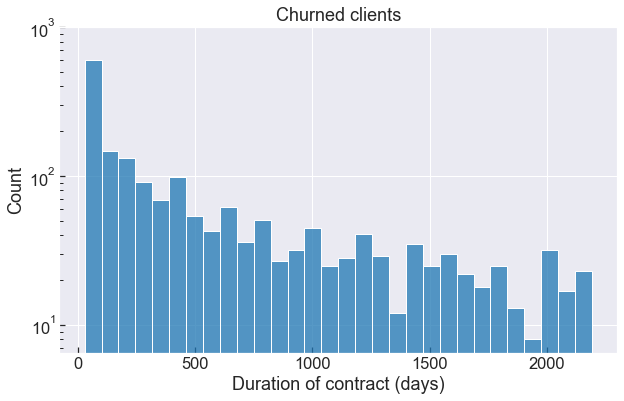

In [6]:
sns.histplot((contract_df['EndDate'] - contract_df['BeginDate']) / np.timedelta64(1,'D'), bins=30)
plt.yscale('log')
plt.ylim(top=1e3)
plt.xlabel('Duration of contract (days)')
plt.title('Churned clients')
plt.show()

### internet

In [7]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
# internet_df['InternetService'] = internet_df['InternetService'].replace({'DSL':True, 'Fiber optic':False})
# for column in internet_df.columns[2:]:
    # internet_df[column] = internet_df[column].replace({'Yes': True, 'No': False}).astype(bool)

In [9]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


### personal

In [11]:
perosnal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
perosnal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


### phone

In [13]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


***

In [14]:
# Объединяю все таблицы в одну
total_df = perosnal_df.merge(contract_df, on='customerID', how='left')
total_df = total_df.merge(internet_df, on='customerID', how='left')
total_df = total_df.merge(phone_df, on='customerID', how='left')

# Унифицирую значения в клонке
total_df['SeniorCitizen'] = total_df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# Отмечаю клиентов, не пользующихся интернетом
for colname in internet_df.columns[1:]:
    total_df[colname] = total_df[colname].fillna('No internet')

# Отмечаю клиентов, не пользующихся телефоном
total_df['MultipleLines'] = total_df['MultipleLines'].fillna('No telephone')

# Дата расторжения договора/выгрузки выборки
total_df['EndOrNowDate'] = total_df['EndDate'].fillna(np.datetime64('2020-02-01'))

# Количество дней, которые клиент провел с компанией
total_df['Days'] = ((total_df['EndOrNowDate'] - total_df['BeginDate']) /
                        np.timedelta64(1,'D')).astype(int)

# Целевая переменная
total_df['Churned'] = ~total_df['EndDate'].isna()

# Признаки, которые не должны попасть в обучающую выборку / не нужны в ней
# 'BeginDate' исключаю, потому что этот признак сильно скоррелирован с 'Days'
total_df = total_df.drop(columns=['customerID', 'BeginDate', 'EndDate', 'EndOrNowDate'])

total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [15]:
total_df.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days,Churned
0,Female,No,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No telephone,31,False
1,Male,No,No,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,1036,False
2,Male,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,61,True
3,Male,No,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,No telephone,1371,False
4,Female,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,61,True


In [54]:
only_internet_users = np.sum(total_df.MultipleLines=='No telephone')

print(f'Пользуются только интернетом: {only_internet_users} ({only_internet_users / len(total_df):.0%})')

Пользуются только интернетом: 682 (10%)


In [94]:
frac_churned = total_df['Churned'].sum() / len(total_df)
print(f'Доля клиентов, расторгнувших договор: {frac_churned:.0%}')
print('Наблюдается дисбаланс классов')

Доля клиентов, расторгнувших договор: 27%
Наблюдается дисбаланс классов


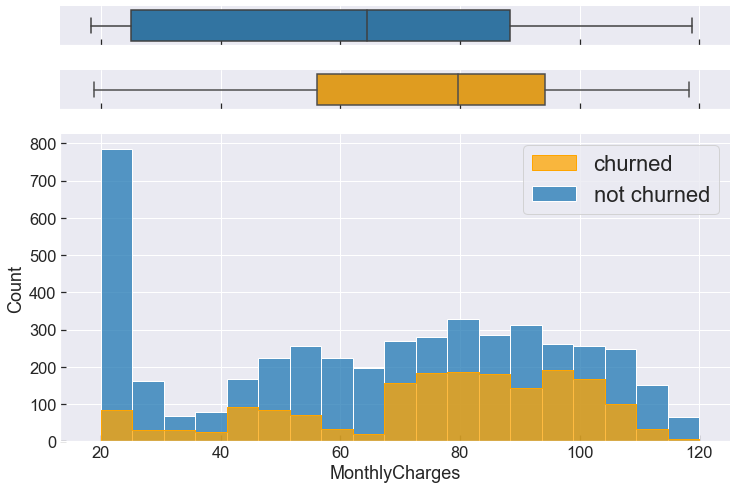

In [95]:
mcarges_not_left = total_df[total_df['Churned']==False]['MonthlyCharges']
mcarges_left = total_df[total_df['Churned']==True]['MonthlyCharges']

_, (ax_box_1, ax_box_2, ax_hist) = plt.subplots(3, sharex=True, figsize=(12, 8),
                                                gridspec_kw={"height_ratios": (.1, .1, .8)})

binspase = np.linspace(20, 120, 20)

sns.boxplot(x=mcarges_not_left, ax=ax_box_1)
sns.histplot(x=mcarges_not_left, bins=binspase, ax=ax_hist,
             fill=True, label='not churned')

sns.boxplot(x=mcarges_left, ax=ax_box_2, color='orange')
sns.histplot(x=mcarges_left, bins=binspase, ax=ax_hist,
             color='orange', element='step', label='churned')

ax_box_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box_1, left=True)

ax_box_2.set(yticks=[], xlabel=None)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box_2, left=True)

ax_hist.legend(fontsize=22)

plt.show()

Клиенты

***

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Days']


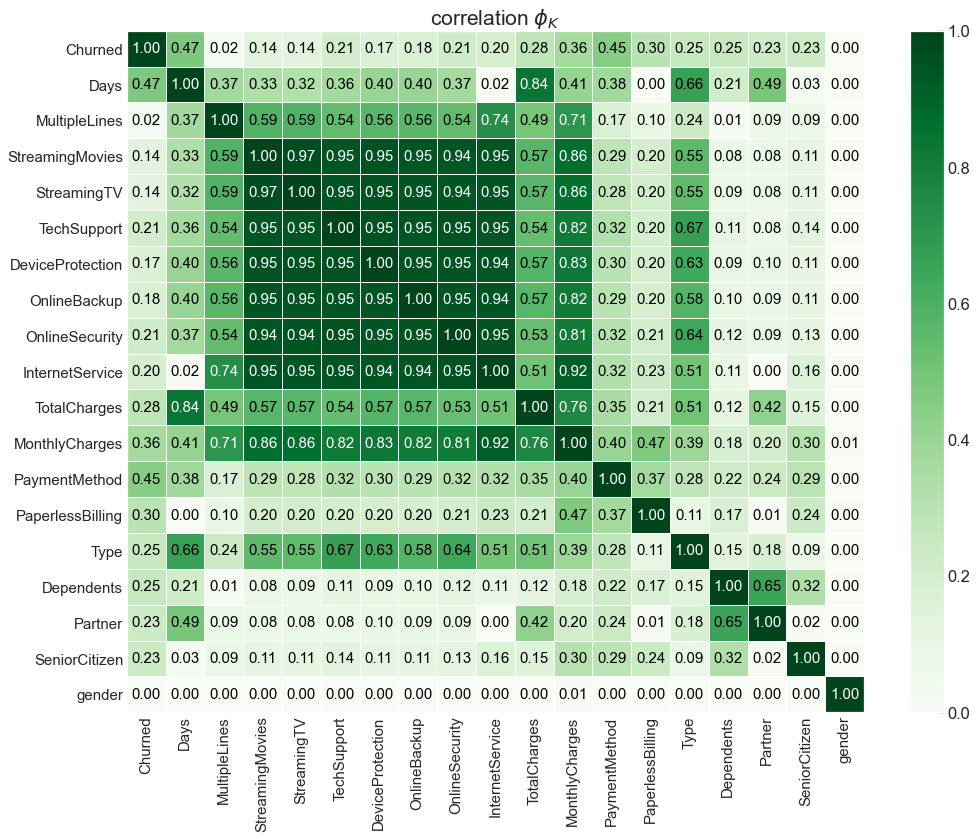

In [17]:
phik_overview = total_df.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 12))
plt.tight_layout()

***

In [18]:
features = total_df.drop(columns=['Churned'])
target = total_df['Churned']

# Разделяю выборку на тренировочную и тестовую
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.2, random_state=42
    )

# Масштабирую признаки
scaler = StandardScaler()
numerical_columns = list(train_features.select_dtypes(include=['int64', 'float64']).columns)
scaler.fit(train_features[numerical_columns])

train_features_scaled = train_features.copy()
test_features_scaled = test_features.copy()

train_features_scaled[numerical_columns] = scaler.transform(train_features[numerical_columns])
test_features_scaled[numerical_columns] = scaler.transform(test_features[numerical_columns])

# One-hot encoding
train_features_ohe_scaled = pd.get_dummies(train_features_scaled)
test_features_ohe_scaled = pd.get_dummies(test_features_scaled)

### Логистическая регрессия

In [45]:
lr_CV_model = LogisticRegressionCV(cv=10, scoring='roc_auc', max_iter=500, class_weight='balanced')
lr_CV_model.fit(train_features_ohe_scaled, train_target)

train_predict = lr_CV_model.predict(train_features_ohe_scaled)
print(f'accuracy для тренировочной выборки: {accuracy_score(train_target, train_predict):.2f}')

test_predict = lr_CV_model.predict(test_features_ohe_scaled)
print(f'accuracy для тестовой выборки: {accuracy_score(test_target, test_predict):.2f}')

accuracy для тренировочной выборки: 0.74
accuracy для тестовой выборки: 0.75


In [49]:
probabilities_test_lr = lr_CV_model.predict_proba(test_features_ohe_scaled)
probabilities_one_test_lr = probabilities_test_lr[:, 1]

auc_roc_test = roc_auc_score(test_target, probabilities_one_test_lr)

probabilities_train_lr = lr_CV_model.predict_proba(train_features_ohe_scaled)
probabilities_one_train_lr = probabilities_train_lr[:, 1]

auc_roc_train = roc_auc_score(train_target, probabilities_one_train_lr)

print(f'AUC-ROC для тренировочной выборки: {auc_roc_train:.2f}')
print(f'AUC-ROC для тестовой выборки: {auc_roc_test:.2f}')

AUC-ROC для тренировочной выборки: 0.84
AUC-ROC для тестовой выборки: 0.86


### Случайный лес

In [79]:
clf = RandomForestClassifier(class_weight='balanced') #Initialize with whatever parameters you want to
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 50, 100],
                 'max_depth': [2, 5, 7, 9, 15]
             }

grid_clf = GridSearchCV(clf, param_grid, cv=10, scoring='roc_auc')
grid_clf.fit(train_features_ohe_scaled, train_target)

GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [2, 5, 7, 9, 15],
                         'n_estimators': [5, 10, 15, 20, 50, 100]},
             scoring='roc_auc')

In [80]:
predictions_test_rf = grid_clf.predict(test_features_ohe_scaled)
probabilities_test_rf = grid_clf.predict_proba(test_features_ohe_scaled)
probabilities_one_test_rf = probabilities_test_rf[:, 1]

predictions_train_rf = grid_clf.predict(train_features_ohe_scaled)
probabilities_train_rf = grid_clf.predict_proba(train_features_ohe_scaled)
probabilities_one_train_rf = probabilities_train_rf[:, 1]

# Calculate the accuracy score
test_accuracy_rf = accuracy_score(test_target, predictions_test_rf)
train_accuracy_rf = accuracy_score(train_target, predictions_train_rf)

test_auc_roc_rf = roc_auc_score(test_target, probabilities_one_test_rf)
train_auc_roc_rf = roc_auc_score(train_target, probabilities_one_train_rf)

print(f'accuracy для тренировочной выборки: {train_accuracy_rf:.2f}')
print(f'accuracy для тестовой выборки: {test_accuracy_rf:.2f}')
print()
print(f'AUC-ROC для тренировочной выборки: {train_auc_roc_rf:.2f}')
print(f'AUC-ROC для тестовой выборки: {test_auc_roc_rf:.2f}')

accuracy для тренировочной выборки: 0.78
accuracy для тестовой выборки: 0.78

AUC-ROC для тренировочной выборки: 0.89
AUC-ROC для тестовой выборки: 0.87


### CatBoost

In [88]:
cat = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.15,
    custom_loss=['AUC', 'Accuracy']
)

cat.fit(train_features_ohe_scaled, train_target,
        eval_set=(test_features_ohe_scaled, test_target),
        verbose=False,
        plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [90]:
cat_pred = cat.predict(test_features_ohe_scaled)
print(f'Accuracy для тестовой выборки: {accuracy_score(test_target, cat_pred.astype(bool)):.2f}')

probabilities_test_cb = cat.predict_proba(test_features_ohe_scaled)
probabilities_one_test_cb = probabilities_test_cb[:, 1]
test_auc_roc_cb = roc_auc_score(test_target, probabilities_one_test_cb)
print(f'AUC-ROC для тестовой выборки: {test_auc_roc_cb:.2f}')

Accuracy для тестовой выборки: 0.26
AUC-ROC для тестовой выборки: 0.94


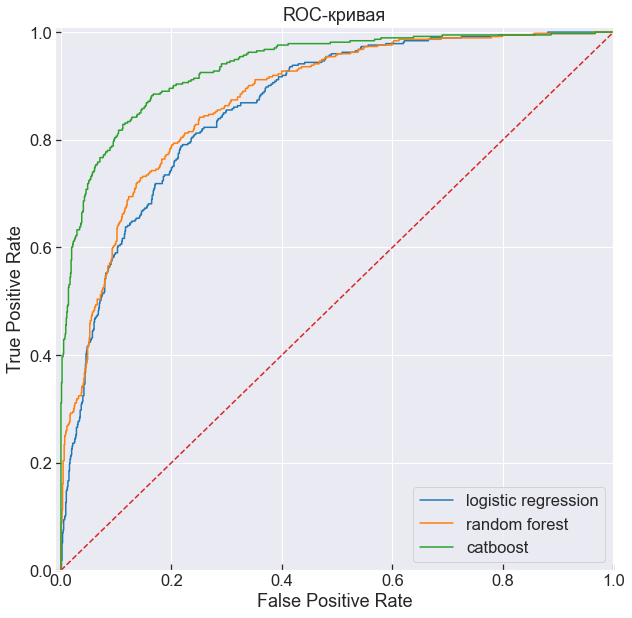

In [93]:
fpr_lr, tpr_lr, thresholds = roc_curve(test_target, probabilities_one_test_lr)
fpr_rf, tpr_rf, thresholds = roc_curve(test_target, probabilities_one_test_rf)
fpr_cb, tpr_cb, thresholds = roc_curve(test_target, probabilities_one_test_cb)

plt.figure(figsize=(10, 10))

plt.plot(fpr_lr, tpr_lr, label='logistic regression')
plt.plot(fpr_rf, tpr_rf, label='random forest')
plt.plot(fpr_cb, tpr_cb, label='catboost')

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-.01, 1])
plt.ylim([0, 1.01])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()

plt.title('ROC-кривая')

plt.show()

***

__Описание услуг__

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание полей данных:
- `BeginDate` – дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами,
- `Type` – тип оплаты: ежемесячный, годовой и тд,
- `PaperlessBilling` – безналичный расчет,
- `PaymentMethod` – способ оплаты,
- `MonthlyCharges` – ежемесячные траты на услуги,
- `TotalCharges` – всего потрачено денег на услуги
- `Dependents` – наличие иждивенцев
- `Senior` Citizen – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и)
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

***

## Дополнительная задача

Телеком: исследование оттока клиентов
Пока создаётся модель прогнозирования оттока клиентов, отдел маркетинга «Ниединогоразрыва.ком» приступает к проработке способов их удержания. Вам предстоит собрать нужную для этого информацию.

Сравните распределения величин ежемесячных платежей (`MonthlyCharges`) всех клиентов и тех, кто ушёл. Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.

Сравните поведение клиентов этих двух групп. Для каждой постройте два любых графика, изображающих:

- долю пользователей телефонной связи;
- долю интернет-пользователей.

***

## План решения задачи

* Выполнить предобработку данных: исследовать пропуски и/или возможные ошибки, привести колонки к соответствующим типам. Разделить данные на тренировочную и тестовую выборку.
* Провести исследовательский анализ данных на тренировочной выборке
* Построить несколько моделей и сравнить качество предсказаний на тестовой выборке (предварительно применив к ней преобразования, обученные на тренировочной)
* Выбрать наилучшую модель и сформулировать выводы